In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

2024-04-18 19:49:14.809390: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-18 19:49:14.832535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 19:49:15.355789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.random.set_seed(42)

In [4]:
'''
Hyperparameters
'''
BATCH_SIZE = 64
IMG_SHAPE = 224

In [15]:
'''
Data Preparation
'''
class DataPrep():
    def __init__(self):
        self.categories = []

    def get_categories(self, directory):
        self.categories = [str(i.name)
                           for i in os.scandir(directory) if i.is_dir()]
        self.categories.sort()
        return self.categories

    def prepare_data(self, directory, batch_size, img_size):
        print('Preparing data...')

        train_generator = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.3,
            horizontal_flip=True,
            dtype='float16')

        val_generator = ImageDataGenerator(rescale=1./255, dtype='float16')

        train_data = train_generator.flow_from_directory(
            directory+'/train',
            batch_size=batch_size,
            target_size=img_size, shuffle=True, seed=42)

        val_data = val_generator.flow_from_directory(
            directory+'/valid',
            batch_size=batch_size,
            target_size=img_size, shuffle=True, seed=42)

        test_data = val_generator.flow_from_directory(
            directory+'/test',
            batch_size=batch_size,
            target_size=img_size, shuffle=False, seed=42)

        print('Data prepared successfully!')
        return train_data, val_data, test_data

In [16]:
'''
Create an instance of the DataPrep class and prepare the data
'''
data_prep = DataPrep()
train_generator, val_generator, test_generator = data_prep.prepare_data(
    directory='100 classes', batch_size=BATCH_SIZE, img_size=(IMG_SHAPE, IMG_SHAPE))
output_classes = train_generator.num_classes
print('Number of output classes:', output_classes)
print('Length of training generator:', train_generator.samples)
print('Length of validation generator:', val_generator.samples)
print('Length of test generator:', test_generator.samples)

Preparing data...
Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Data prepared successfully!
Number of output classes: 100
Length of training generator: 13492
Length of validation generator: 500
Length of test generator: 500


In [6]:
'''
Model
'''
class ProjectModel():
    def __init__(self, output_classes, input_shape):
        print('Initializing model...')
        self.output_classes = output_classes
        self.input_shape = input_shape
        self.model = self.build_model()

    def build_model(self):
        base_model = tf.keras.applications.ConvNeXtXLarge(include_top=False, input_shape=self.input_shape)
        base_model.trainable = False

        inputs = tf.keras.Input(shape=self.input_shape)
        x = base_model(inputs, training=False) 

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1024, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.3)(x)

        outputs = tf.keras.layers.Dense(self.output_classes, activation='softmax')(x)

        # Combine the input and output layers to create the final model
        model = tf.keras.models.Model(inputs, outputs)
        return model

    def train_model(self, train_generator, val_generator, epochs, batch_size):
        print('Performing training ...')
        print(self.model.summary())

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True)

        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            'model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        
        self.model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
        self.model.layers[1].trainable = True

        for layer in self.model.layers[1].layers[:-10]:
            layer.trainable = False

        for layer in self.model.layers[1].layers:
            print(layer, layer.trainable)
            
        history = self.model.fit(train_generator, epochs=epochs,
                       batch_size=batch_size, validation_data=val_generator, callbacks=[early_stopping, checkpoint])

        self.model.save('model.keras')

        return history

    def predict(self, image, categories):
        print('Predicting...')
        image = Image.open(image)
        image = image.resize(self.input_shape[:2])
        image = image.convert('RGB')
        image = np.array(image) / 255.0
        image = np.expand_dims(image, axis=0)  # Add a batch dimension
        perd = self.model.predict(image)
        pred_class = categories[np.argmax(perd)]
        print('Predicted class:', pred_class)

    def load(self, path):
        print('Loading model...')
        self.model.load_weights(path)
        self.model.summary()

    def save(self, path):
        print('Saving model...')
        self.model.save_weights(path)

In [7]:
'''
Create an instance of the Model class and train the model, then evaluate it
'''
# Clear backend
tf.keras.backend.clear_session()
model = ProjectModel(output_classes=output_classes, input_shape=(IMG_SHAPE, IMG_SHAPE, 3))
history = model.train_model(train_generator, val_generator, epochs=30, batch_size=BATCH_SIZE)

Initializing model...


2024-04-18 15:40:45.871908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 15:40:45.887568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 15:40:45.887692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Performing training ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 convnext_xlarge (Functional  (None, 7, 7, 2048)       348147968 
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1

2024-04-18 15:40:49.646485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/home/sunehildeep/miniconda3/envs/ai/lib/python3.11/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-04-18 15:40:55.114161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2024-04-18 15:40:55.966633: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-04-18 15:40:55.997261: I tensorflow/compiler/xla/stream_executo

211/211 [==============================] - ETA: 0s - loss: 2.7991 - accuracy: 0.3960

2024-04-18 15:45:58.625591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.05284, saving model to model.keras
211/211 [==============================] - 328s 2s/step - loss: 2.7991 - accuracy: 0.3960 - val_loss: 1.0528 - val_accuracy: 0.7600
Epoch 2/30
211/211 [==============================] - ETA: 0s - loss: 1.4507 - accuracy: 0.6387
Epoch 2: val_loss improved from 1.05284 to 0.67237, saving model to model.keras
211/211 [==============================] - 313s 1s/step - loss: 1.4507 - accuracy: 0.6387 - val_loss: 0.6724 - val_accuracy: 0.8120
Epoch 3/30
211/211 [==============================] - ETA: 0s - loss: 1.1274 - accuracy: 0.7085
Epoch 3: val_loss improved from 0.67237 to 0.53155, saving model to model.keras
211/211 [==============================] - 313s 1s/step - loss: 1.1274 - accuracy: 0.7085 - val_loss: 0.5315 - val_accuracy: 0.8500
Epoch 4/30
211/211 [==============================] - ETA: 0s - loss: 0.9825 - accuracy: 0.7384
Epoch 4: val_loss improved from 0.53155 to 0.42767, saving model to model.keras

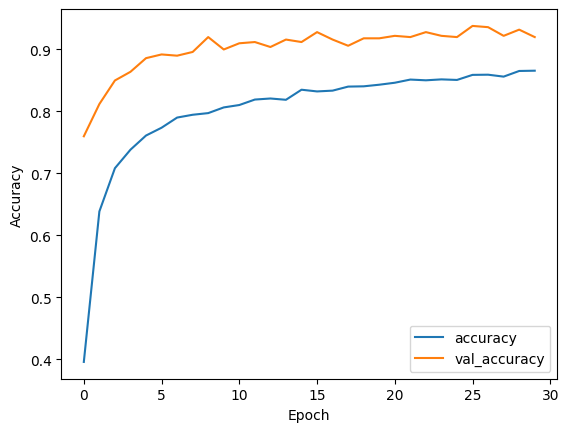

In [8]:
'''
Plot the training history
'''
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history)

In [19]:
'''
Evaluation
'''
from LayerScale import LayerScale
model = tf.keras.models.load_model('model.keras', custom_objects={'LayerScale': LayerScale})
print("Loss and Accuracy on test dataset:")
print(model.evaluate(test_generator))


Loss and Accuracy on test dataset:


2024-04-18 20:00:28.965454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/home/sunehildeep/miniconda3/envs/ai/lib/python3.11/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - 15s 2s/step - loss: 0.2678 - accuracy: 0.9380
[0.26779088377952576, 0.9380000233650208]


In [18]:
print('Classification Report:')
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:


2024-04-18 20:00:14.006003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 11s 1s/step
                       precision    recall  f1-score   support

           air hockey       1.00      0.80      0.89         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       0.83      1.00      0.91         5
         balance beam       0.83      1.00      0.91         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      0.80      0.89         5
           basketball       1.00      0.80      0.89         5
       baton twirling       1.00      0.80      0.89         5
            bike polo       1.00      1.00      1.00         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.60      0.75         5
              bobsled       1.00      1.00      1.00         5
   

Confusion Matrix:


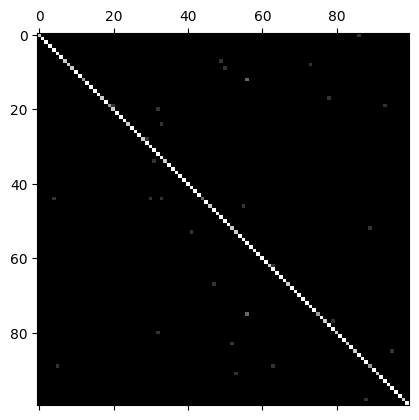

In [22]:
print('Confusion Matrix:')
conf_matrix = confusion_matrix(y_true, y_pred)
plt.matshow(conf_matrix, cmap='gray')
